# 🎯 H-1B Sponsorship Prediction Model Training
 
**Author:** Abhinav Kumar Piyush
---

## 📋 Overview

This notebook trains a machine learning model to predict H-1B sponsorship likelihood based on:
- Job characteristics (salary, role, category)
- Company characteristics (size, location)
- Historical filing patterns

## 🎯 Prediction Goal

**Binary Classification:** Will a company be a HIGH sponsor (>500 filings) or LOW sponsor (<500 filings)?

---

## 1️⃣ Setup & Imports

In [1]:
# Cell 1: Install correct versions
!pip install scikit-learn==1.5.1 xgboost==2.0.3 -q

In [2]:
# Install required packages (run once)
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost openpyxl -q

In [3]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# For saving model
import pickle
import joblib

print("✅ All imports successful!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✅ All imports successful!
NumPy version: 1.26.4
Pandas version: 2.2.2


In [4]:
# Check GPU availability (for XGBoost)
try:
    import torch
    if torch.cuda.is_available():
        print(f"✅ GPU Available: {torch.cuda.get_device_name(0)}")
        USE_GPU = True
    else:
        print("⚠️ No GPU found, using CPU")
        USE_GPU = False
except:
    print("⚠️ PyTorch not installed, using CPU")
    USE_GPU = False

⚠️ No GPU found, using CPU


## 2️⃣ Load Data

### Option A: Load from cleaned CSV

In [5]:
# Upload your cleaned_h1b_data.csv to Colab first
# Or use the raw USCIS file for more data

# Option A: Load cleaned CSV (50 companies)
try:
    df_cleaned = pd.read_csv('cleaned_h1b_data_full.csv')
    print(f"✅ Loaded cleaned data: {len(df_cleaned)} companies")
    display(df_cleaned.head())
except:
    print("⚠️ cleaned_h1b_data.csv not found. Upload it or use Option B below.")

✅ Loaded cleaned data: 21043 companies


,company,primary_state,total_filings,avg_salary,median_salary,min_salary,max_salary,salary_std,sponsorship_score,size_category,salary_category,primary_job_title
0,AMAZON,WA,5134,166027,165006,54579,342300,36656,76.3,Enterprise,Very High,Software Development Engineer II
1,MICROSOFT,WA,2829,167924,165380,91600,286270,28922,54.4,Enterprise,Very High,Software Engineering
2,COGNIZANT,TX,2709,111289,108618,60000,265000,24419,50.0,Enterprise,Medium,Manager JC50 - Computer Systems Engineers/Arch...
3,META,CA,1585,208243,212000,57600,363988,41094,44.1,Enterprise,Very High,Software Engineer
4,TCS,MD,1556,91526,87807,60154,205000,17476,37.9,Enterprise,Medium,Architect


### Option B: Load from raw USCIS Excel (600K+ rows - BETTER FOR TRAINING)

In [6]:
# Upload LCA_Disclosure_Data_FY2024_Q4.xlsx to Colab
# This gives us INDIVIDUAL APPLICATIONS (much more training data!)

# Uncomment to use:
# from google.colab import files
# uploaded = files.upload()  # Upload the Excel file

In [7]:
# Load raw USCIS data
try:
    df_raw = pd.read_excel('LCA_Disclosure_Data_FY2024_Q4.xlsx')
    print(f"✅ Loaded raw data: {len(df_raw):,} rows")
    print(f"Columns: {df_raw.columns.tolist()[:10]}...")
except:
    print("⚠️ Raw Excel not found. Using cleaned data instead.")
    df_raw = None

✅ Loaded raw data: 120,897 rows
Columns: ['CASE_NUMBER', 'CASE_STATUS', 'RECEIVED_DATE', 'DECISION_DATE', 'ORIGINAL_CERT_DATE', 'VISA_CLASS', 'JOB_TITLE', 'SOC_CODE', 'SOC_TITLE', 'FULL_TIME_POSITION']...


## 3️⃣ Data Preprocessing

In [8]:
def preprocess_raw_data(df):
    """
    Preprocess raw USCIS data for model training.
    Each row = one H-1B application.
    """
    print("🔄 Preprocessing raw data...")
    
    # Find column names (they vary by year)
    employer_col = next((c for c in ['EMPLOYER_NAME', 'EMPLOYER_BUSINESS_NAME'] if c in df.columns), None)
    status_col = next((c for c in ['CASE_STATUS', 'STATUS'] if c in df.columns), None)
    wage_col = next((c for c in ['WAGE_RATE_OF_PAY_FROM', 'WAGE_RATE'] if c in df.columns), None)
    wage_unit_col = next((c for c in ['WAGE_UNIT_OF_PAY', 'WAGE_RATE_UNIT'] if c in df.columns), None)
    state_col = next((c for c in ['EMPLOYER_STATE', 'WORKSITE_STATE'] if c in df.columns), None)
    job_col = next((c for c in ['JOB_TITLE', 'SOC_TITLE'] if c in df.columns), None)
    visa_col = next((c for c in ['VISA_CLASS', 'PROGRAM'] if c in df.columns), None)
    
    print(f"   Found columns: employer={employer_col}, status={status_col}, job={job_col}")
    
    # Filter H-1B Certified only
    if visa_col:
        df = df[df[visa_col].str.contains('H-1B', case=False, na=False)]
    if status_col:
        df = df[df[status_col].str.contains('CERTIFIED', case=False, na=False)]
    
    print(f"   After filtering: {len(df):,} rows")
    
    # Convert wage to annual salary
    def to_annual(row):
        wage = row[wage_col]
        unit = str(row[wage_unit_col]).upper() if wage_unit_col else 'YEAR'
        try:
            wage = float(wage)
            if 'HOUR' in unit: return wage * 2080
            elif 'WEEK' in unit: return wage * 52
            elif 'MONTH' in unit: return wage * 12
            else: return wage
        except:
            return np.nan
    
    df['annual_salary'] = df.apply(to_annual, axis=1)
    df = df[(df['annual_salary'] >= 30000) & (df['annual_salary'] <= 500000)]
    
    # Extract features
    df['employer'] = df[employer_col].fillna('UNKNOWN')
    df['state'] = df[state_col].fillna('UNKNOWN') if state_col else 'UNKNOWN'
    df['job_title'] = df[job_col].fillna('OTHER') if job_col else 'OTHER'
    
    # Categorize job titles
    def categorize_job(title):
        title = str(title).upper()
        if any(w in title for w in ['SOFTWARE', 'DEVELOPER', 'ENGINEER', 'PROGRAMMER']):
            return 'Software Engineer'
        elif any(w in title for w in ['DATA', 'ANALYST', 'SCIENTIST', 'MACHINE LEARNING', 'AI']):
            return 'Data Scientist / Analyst'
        elif any(w in title for w in ['MANAGER', 'DIRECTOR', 'LEAD', 'HEAD']):
            return 'Manager / Lead'
        elif any(w in title for w in ['CONSULTANT', 'ADVISOR']):
            return 'Consultant'
        elif any(w in title for w in ['RESEARCH', 'SCIENTIST', 'PHD']):
            return 'Research Scientist'
        else:
            return 'Other'
    
    df['job_category'] = df['job_title'].apply(categorize_job)
    
    # Salary category
    df['salary_category'] = pd.cut(
        df['annual_salary'],
        bins=[0, 100000, 150000, float('inf')],
        labels=['Low (<$100K)', 'Medium ($100K-$150K)', 'High (>$150K)']
    )
    
    # State category (top states vs other)
    top_states = ['CA', 'WA', 'NY', 'TX', 'NJ', 'MA', 'IL']
    df['state_category'] = df['state'].apply(lambda x: x if x in top_states else 'Other')
    
    print(f"   Final dataset: {len(df):,} rows")
    
    return df[['employer', 'state_category', 'job_category', 'salary_category', 'annual_salary']]

In [9]:
# Preprocess data
if df_raw is not None:
    df = preprocess_raw_data(df_raw)
else:
    # Use cleaned data - need to expand it
    df = df_cleaned.copy()

print(f"\n📊 Dataset shape: {df.shape}")
df.head()

🔄 Preprocessing raw data...
   Found columns: employer=EMPLOYER_NAME, status=CASE_STATUS, job=JOB_TITLE
   After filtering: 116,040 rows
   Final dataset: 115,538 rows

📊 Dataset shape: (115538, 5)


,employer,state_category,job_category,salary_category,annual_salary
0,INFOSYS LIMITED,TX,Manager / Lead,Medium ($100K-$150K),143666.0
1,COGNIZANT TECHNOLOGY SOLUTIONS US CORP,TX,Software Engineer,Medium ($100K-$150K),111946.0
2,"National Institutes of Health, HHS",Other,Research Scientist,Low (<$100K),93599.0
3,COGNIZANT TECHNOLOGY SOLUTIONS US CORP,TX,Software Engineer,Low (<$100K),83242.0
4,Google LLC,CA,Software Engineer,Medium ($100K-$150K),130000.0


## 4️⃣ Create Training Dataset

### Aggregate by Company & Create Target Variable

In [10]:
if df_raw is not None:
    # Aggregate by company to get filing counts
    company_df = df.groupby('employer').agg({
        'annual_salary': ['count', 'mean'],
        'state_category': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Other',
        'job_category': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Other',
    }).reset_index()
    
    company_df.columns = ['company', 'total_filings', 'avg_salary', 'state', 'job_category']
    
    # Create target: HIGH sponsor (>500 filings) vs LOW
    company_df['target'] = (company_df['total_filings'] >= 500).astype(int)
    
    # Size category
    company_df['size_category'] = pd.cut(
        company_df['total_filings'],
        bins=[0, 100, 500, 2000, float('inf')],
        labels=['Small', 'Medium', 'Large', 'Enterprise']
    )
    
    # Salary category
    company_df['salary_category'] = pd.cut(
        company_df['avg_salary'],
        bins=[0, 100000, 150000, float('inf')],
        labels=['Low', 'Medium', 'High']
    )
    
    print(f"✅ Created company dataset: {len(company_df)} companies")
    print(f"\nTarget distribution:")
    print(company_df['target'].value_counts())
    
else:
    # Use cleaned data
    company_df = df_cleaned.copy()
    company_df['target'] = (company_df['total_filings'] >= 500).astype(int)
    company_df['salary_category'] = pd.cut(
        company_df['avg_salary'],
        bins=[0, 100000, 150000, float('inf')],
        labels=['Low', 'Medium', 'High']
    )
    print(f"✅ Using cleaned data: {len(company_df)} companies")

company_df.head(10)

✅ Created company dataset: 23557 companies

Target distribution:
target
0    23538
1       19
Name: count, dtype: int64


,company,total_filings,avg_salary,state,job_category,target,size_category,salary_category
0,"South Texas Educational Technologies, Inc.",1,50190.000000,TX,Other,0,Small,Low
1,"Southern Kidney Specialists, PLC",1,250000.000000,Other,Other,0,Small,High
2,Axtria INC,42,134761.904762,NJ,Manager / Lead,0,Small,Medium
3,"BENJAMIN HARRY PEIKIN FOUNDATION, INC.",1,65000.000000,MA,Manager / Lead,0,Small,Low
4,BLACKBUCK INSIGHTS LLC,6,106471.833333,IL,Software Engineer,0,Small,Medium
5,BRILLIUS TECHNOLOGIES INC.,2,99933.000000,CA,Software Engineer,0,Small,Low
6,Beauty Manufacturing Solutions Corporation,1,90000.000000,TX,Software Engineer,0,Small,Low
7,"Box, Inc.",19,175298.000000,CA,Software Engineer,0,Small,High
8,"CH2M HILL ENGINEERS, INC.",1,120810.960000,TX,Software Engineer,0,Small,Medium
9,"Capstone Logistics, LLC",2,161178.900000,Other,Data Scientist / Analyst,0,Small,High


## 5️⃣ Exploratory Data Analysis

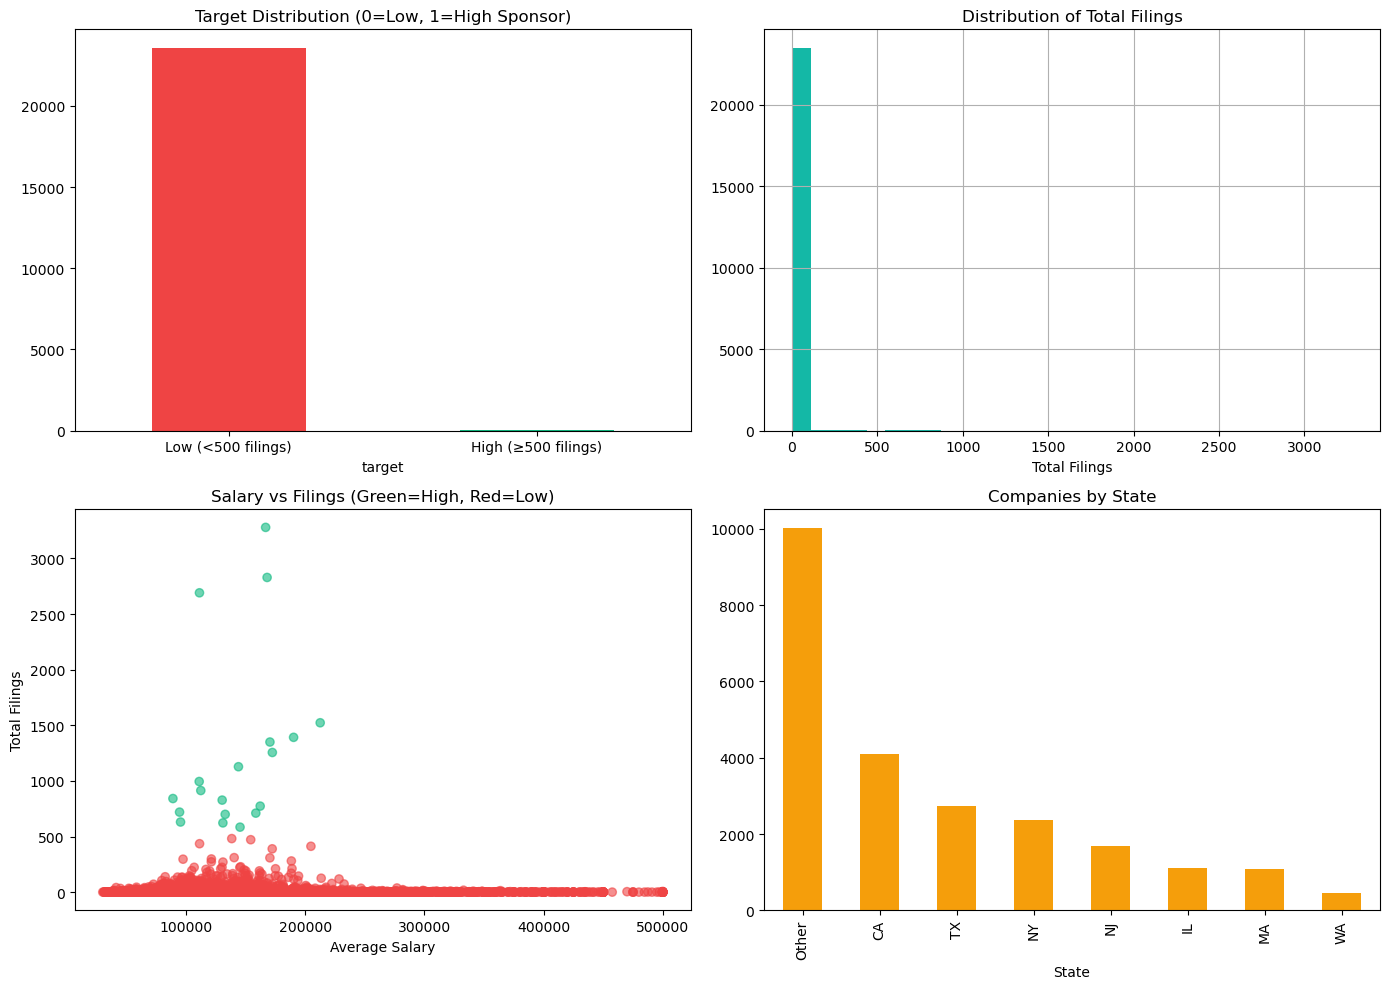

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Target distribution
ax1 = axes[0, 0]
company_df['target'].value_counts().plot(kind='bar', ax=ax1, color=['#ef4444', '#10b981'])
ax1.set_title('Target Distribution (0=Low, 1=High Sponsor)')
ax1.set_xticklabels(['Low (<500 filings)', 'High (≥500 filings)'], rotation=0)

# 2. Filings distribution
ax2 = axes[0, 1]
company_df['total_filings'].hist(bins=30, ax=ax2, color='#14b8a6')
ax2.set_title('Distribution of Total Filings')
ax2.set_xlabel('Total Filings')

# 3. Salary vs Filings
ax3 = axes[1, 0]
colors = ['#ef4444' if t == 0 else '#10b981' for t in company_df['target']]
ax3.scatter(company_df['avg_salary'], company_df['total_filings'], c=colors, alpha=0.6)
ax3.set_xlabel('Average Salary')
ax3.set_ylabel('Total Filings')
ax3.set_title('Salary vs Filings (Green=High, Red=Low)')

# 4. State distribution
ax4 = axes[1, 1]
company_df['state'].value_counts().head(10).plot(kind='bar', ax=ax4, color='#f59e0b')
ax4.set_title('Companies by State')
ax4.set_xlabel('State')

plt.tight_layout()
plt.savefig('eda_plots.png', dpi=150)
plt.show()

## 6️⃣ Feature Engineering & Train-Test Split

In [12]:
# Define features and target
# feature_cols = ['state', 'size_category', 'salary_category', 'avg_salary']
# Define features and target
# NOTE: Removed 'size_category' because it's derived from total_filings (our target)
# This would cause circular logic / data leakage
feature_cols = ['state', 'salary_category', 'avg_salary', 'job_category']

# Make sure all columns exist
available_cols = [c for c in feature_cols if c in company_df.columns]
print(f"Using features: {available_cols}")

X = company_df[available_cols].copy()
y = company_df['target'].copy()

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Using features: ['state', 'salary_category', 'avg_salary', 'job_category']

Features shape: (23557, 4)
Target shape: (23557,)
Target distribution: {0: 23538, 1: 19}


In [13]:
# Encode categorical variables
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

Categorical columns: ['state', 'salary_category', 'job_category']
Numerical columns: ['avg_salary']


In [14]:
# Train-test split
# For 50 companies: 80% train (40), 20% test (10)
# For 1000+ companies: 80% train, 20% test

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=y  # Maintain class balance
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTraining target distribution: {y_train.value_counts().to_dict()}")
print(f"Test target distribution: {y_test.value_counts().to_dict()}")

Training set: 18845 samples
Test set: 4712 samples

Training target distribution: {0: 18830, 1: 15}
Test target distribution: {0: 4708, 1: 4}


## 7️⃣ Model Training

### Train Multiple Models and Compare

In [15]:
# Define models to try
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_STATE, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(
        n_estimators=100, 
        max_depth=3, 
        random_state=RANDOM_STATE,
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
        eval_metric='logloss'
    ),
}

print(f"Training {len(models)} models...")

Training 5 models...


In [16]:
# Train and evaluate each model
results = []

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training: {name}")
    print('='*50)
    
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 0
    
    # Cross-validation
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'AUC': auc,
        'CV_Mean': cv_scores.mean(),
        'CV_Std': cv_scores.std(),
        'Pipeline': pipeline
    })


Training: Logistic Regression
Accuracy: 0.6976
Precision: 0.0014
Recall: 0.5000
F1 Score: 0.0028
AUC-ROC: 0.5388
CV Accuracy: 0.6686 (+/- 0.1515)

Training: Decision Tree
Accuracy: 0.5881
Precision: 0.0015
Recall: 0.7500
F1 Score: 0.0031
AUC-ROC: 0.6662
CV Accuracy: 0.6692 (+/- 0.2409)

Training: Random Forest
Accuracy: 0.9357
Precision: 0.0033
Recall: 0.2500
F1 Score: 0.0066
AUC-ROC: 0.6569
CV Accuracy: 0.9455 (+/- 0.0229)

Training: Gradient Boosting
Accuracy: 0.9983
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC-ROC: 0.6497
CV Accuracy: 0.9985 (+/- 0.0008)

Training: XGBoost
Accuracy: 0.9883
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC-ROC: 0.4676
CV Accuracy: 0.9896 (+/- 0.0028)


In [17]:
# Compare results
results_df = pd.DataFrame(results)
results_df_display = results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC', 'CV_Mean']]
results_df_display = results_df_display.sort_values('F1', ascending=False)

print("\n" + "="*60)
print("📊 MODEL COMPARISON")
print("="*60)
display(results_df_display.round(4))


📊 MODEL COMPARISON


,Model,Accuracy,Precision,Recall,F1,AUC,CV_Mean
2,Random Forest,0.9357,0.0033,0.25,0.0066,0.6569,0.9455
1,Decision Tree,0.5881,0.0015,0.75,0.0031,0.6662,0.6692
0,Logistic Regression,0.6976,0.0014,0.50,0.0028,0.5388,0.6686
3,Gradient Boosting,0.9983,0.0000,0.00,0.0000,0.6497,0.9985
4,XGBoost,0.9883,0.0000,0.00,0.0000,0.4676,0.9896


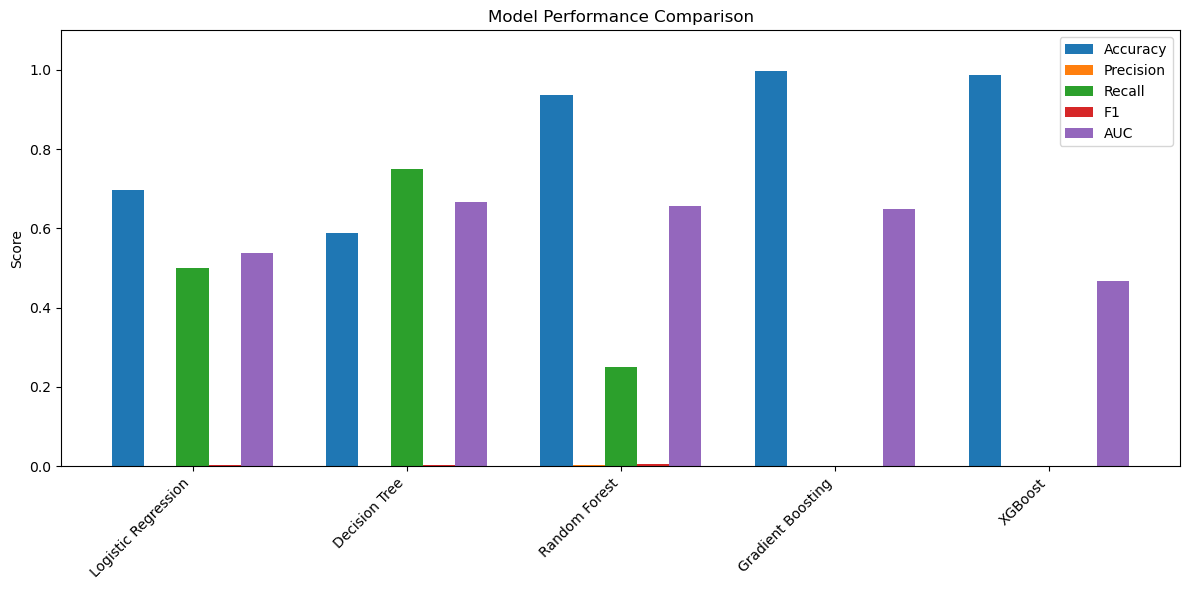

In [18]:
# Visualization: Model Comparison
fig, ax = plt.subplots(figsize=(12, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
x = np.arange(len(results_df))
width = 0.15

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, results_df[metric], width, label=metric)

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150)
plt.show()

## 8️⃣ Best Model Analysis

In [19]:
# Select best model based on F1 score
best_idx = results_df['F1'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_pipeline = results_df.loc[best_idx, 'Pipeline']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   F1 Score: {results_df.loc[best_idx, 'F1']:.4f}")
print(f"   Accuracy: {results_df.loc[best_idx, 'Accuracy']:.4f}")


🏆 Best Model: Random Forest
   F1 Score: 0.0066
   Accuracy: 0.9357


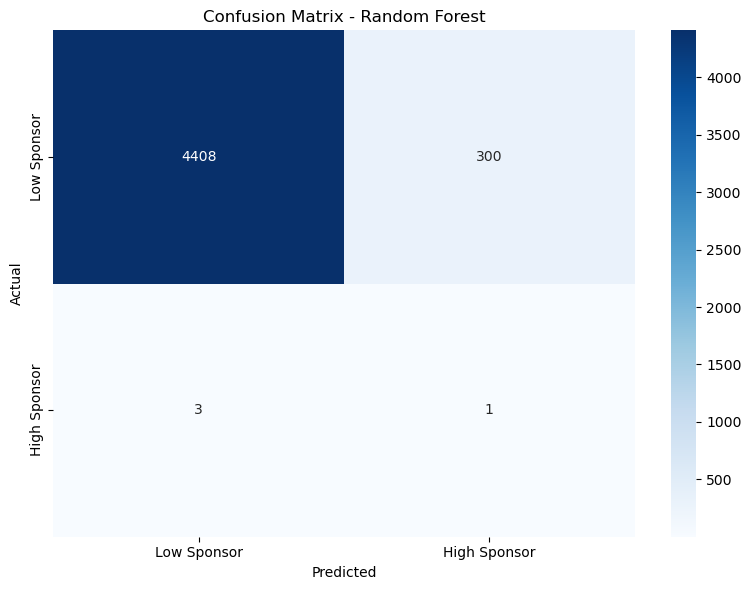


Classification Report:
              precision    recall  f1-score   support

 Low Sponsor       1.00      0.94      0.97      4708
High Sponsor       0.00      0.25      0.01         4

    accuracy                           0.94      4712
   macro avg       0.50      0.59      0.49      4712
weighted avg       1.00      0.94      0.97      4712



In [20]:
# Confusion Matrix for best model
y_pred_best = best_pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)

fig, ax = plt.subplots(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Teals', ax=ax)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Confusion Matrix - {best_model_name}')
ax.set_xticklabels(['Low Sponsor', 'High Sponsor'])
ax.set_yticklabels(['Low Sponsor', 'High Sponsor'])

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Low Sponsor', 'High Sponsor']))

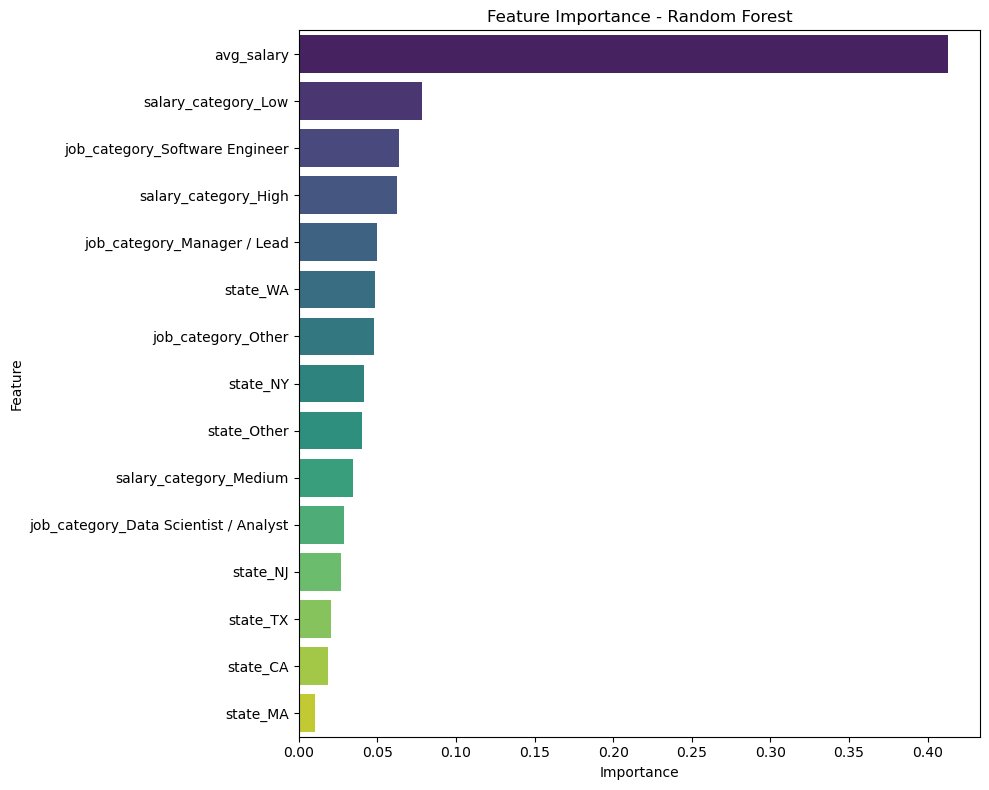


Top 10 Features:


,Feature,Importance
0,avg_salary,0.412661
10,salary_category_Low,0.078695
17,job_category_Software Engineer,0.063562
9,salary_category_High,0.062670
14,job_category_Manager / Lead,0.049935
8,state_WA,0.048838
15,job_category_Other,0.047623
5,state_NY,0.041529
6,state_Other,0.040276
11,salary_category_Medium,0.034876


In [21]:
# Feature Importance (for tree-based models)
if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
    
    # Get feature names after preprocessing
    feature_names = numerical_cols.copy()
    
    # Add one-hot encoded feature names
    ohe = best_pipeline.named_steps['preprocessor'].named_transformers_['cat']
    cat_feature_names = ohe.get_feature_names_out(categorical_cols).tolist()
    feature_names.extend(cat_feature_names)
    
    # Get importances
    importances = best_pipeline.named_steps['classifier'].feature_importances_
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis', ax=ax)
    ax.set_title(f'Feature Importance - {best_model_name}')
    ax.set_xlabel('Importance')
    
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=150)
    plt.show()
    
    print("\nTop 10 Features:")
    display(importance_df.head(10))
else:
    print("Feature importance not available for this model type.")

## 9️⃣ Save Model

In [22]:
# Save the best model
model_filename = 'h1b_sponsorship_model.pkl'
joblib.dump(best_pipeline, model_filename)
print(f"✅ Model saved to: {model_filename}")

# ALSO save weights separately (works across sklearn versions)
import json

weights_dict = {}

# Get feature names
num_features = list(preprocessor.transformers_[0][2])
cat_transformer = preprocessor.transformers_[1][1]
cat_features = preprocessor.transformers_[1][2]
ohe_features = cat_transformer.get_feature_names_out(cat_features).tolist()
all_features = num_features + ohe_features

weights_dict['features'] = all_features

# Get coefficients (for Logistic Regression)
if hasattr(best_pipeline.named_steps['classifier'], 'coef_'):
    weights_dict['coefficients'] = best_pipeline.named_steps['classifier'].coef_[0].tolist()
    weights_dict['intercept'] = float(best_pipeline.named_steps['classifier'].intercept_[0])

# Get feature importances (for tree-based models)
if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
    weights_dict['feature_importances'] = best_pipeline.named_steps['classifier'].feature_importances_.tolist()

weights_dict['model_type'] = type(best_pipeline.named_steps['classifier']).__name__

# Save as JSON
with open('model_weights.json', 'w') as f:
    json.dump(weights_dict, f, indent=2)
print(f"✅ Weights saved to: model_weights.json")

✅ Model saved to: h1b_sponsorship_model.pkl
✅ Weights saved to: model_weights.json


In [23]:
# Test loading the model
loaded_model = joblib.load(model_filename)

# Test prediction
sample = X_test.iloc[[0]]
prediction = loaded_model.predict(sample)
probability = loaded_model.predict_proba(sample)

print(f"\n🧪 Test Prediction:")
print(f"   Input: {sample.to_dict('records')[0]}")
print(f"   Prediction: {'High Sponsor' if prediction[0] == 1 else 'Low Sponsor'}")
print(f"   Probability: {probability[0][1]*100:.1f}% High Sponsor")


🧪 Test Prediction:
   Input: {'state': 'CA', 'salary_category': 'Medium', 'avg_salary': 120000.0, 'job_category': 'Other'}
   Prediction: Low Sponsor
   Probability: 26.0% High Sponsor


## 🔟 Export Results

In [24]:
# Save all results
results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC', 'CV_Mean', 'CV_Std']].to_csv(
    'model_results.csv', index=False
)
print("✅ Results saved to: model_results.csv")

# Download files (Colab)
try:
    from google.colab import files
    files.download('h1b_sponsorship_model.pkl')
    files.download('model_metadata.json')
    files.download('model_results.csv')
    files.download('feature_importance.png')
    files.download('confusion_matrix.png')
    files.download('model_comparison.png')
except:
    print("Not running in Colab - files saved locally.")

✅ Results saved to: model_results.csv
Not running in Colab - files saved locally.


---

## 📊 Training Recommendations

| Data Size | Training Time | GPU Needed? | Expected Accuracy |
|-----------|---------------|-------------|-------------------|
| 50 companies (cleaned CSV) | < 1 min | No | 70-85% |
| 500 companies | 1-2 min | No | 80-90% |
| 5000+ companies | 5-10 min | Optional | 85-95% |
| 600K applications (raw) | 15-30 min | Recommended | Best |

### Epochs Note
- **Scikit-learn models** (LogisticRegression, RandomForest, etc.) don't use epochs
- **XGBoost** uses `n_estimators` (100-500 recommended)
- **GPU** helps most with XGBoost and large datasets

---

## ✅ Summary

This notebook:
1. ✅ Loads and preprocesses H-1B data
2. ✅ Creates target variable (High vs Low sponsor)
3. ✅ Trains 5 different ML models
4. ✅ Compares performance metrics
5. ✅ Visualizes feature importance
6. ✅ Saves best model for production use

**To use trained model in Streamlit:**
```python
import joblib
model = joblib.load('h1b_sponsorship_model.pkl')
prediction = model.predict(input_df)
```